In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

<img src="FeedForward.png" alt="drawing" width="600"/>

### Load Data

In [2]:
from sklearn.datasets import make_moons
X,y = make_moons(n_samples = 50, noise = 0.2, random_state=42)

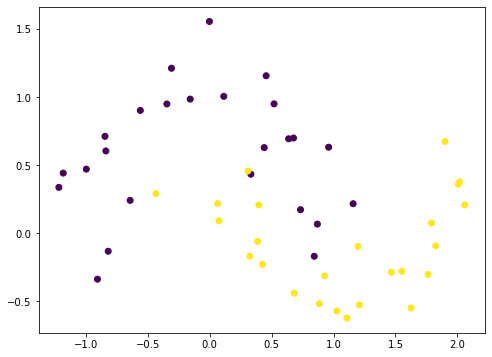

In [3]:
plt.figure(figsize = (8,6))
plt.scatter(X[:,0], X[:,1], c = y)

### Add Bias

In [4]:
def add_bias(arr):
    arr = np.hstack([arr,np.ones((arr.shape[0], 1))]) 
    return arr

In [5]:
X = add_bias(X)

In [6]:
X.shape

(50, 3)

### Define activation function

In [7]:
def sigmoid(X):
    s = 1/(1+np.exp(-X))
    return s

##### Test if you have the correct function with following code

In [8]:
a = np.array([-10.0, -1.0, 0.0, 1.0, 10.0])
expected = np.array([0.0, 0.27, 0.5, 0.73, 1.0])
assert np.all(sigmoid(a).round(2) == expected)

### Weights
Initialize them randomly
- HOW MANY: 3x2 for the input layer w1, w2, bias into the hidden layer and 3x1 from the hidden layer into the output layer
- SHAPE: 
    - First layer (3,2): 3 weights flow into two neurons
    - Hidden layer (2,1): 2 weights flow into one neuron

In [9]:
weights_h = np.random.normal(size = (3,2))
weights_o = np.random.normal(size = (3,1))

In [10]:
X.shape, weights_h.shape

((50, 3), (3, 2))

In [11]:
def feed_forward(X, weights):

    """
    1. Calculate the dot product of X
       and the weights of the first layer.

    2. Apply the sigmoid function on the result.

    3. Append an extra column of ones to the result (i.e. the bias).

    4. Calculate the dot product of the previous step
       with the weights of the second (i.e. outer) layer.

    5. Apply the sigmoid function on the result.

    6. Return all intermediate results (i.e. anything that is outputted
       by an activation function).
    """
    # H_in
    weighted_sum = np.dot(X, weights[0])
    # H_out
    output_1 = sigmoid(weighted_sum)
    print(f'Shape of H_in = {weighted_sum.shape}')
    input_out = add_bias(output_1)
    # O_in
    weighted_sum = np.dot(input_out, weights[1])
    # O_out -> actual prediction
    output_2 = sigmoid(weighted_sum)
    
    return output_1, output_2

### Assertion Test

In [12]:
out1, out2 = feed_forward(X, [weights_h, weights_o])

Shape of H_in = (50, 2)


In [13]:
out1, out2 = feed_forward(X, [weights_h, weights_o])
assert out1.shape == (50, 2)
assert out2.shape == (50, 1)

Shape of H_in = (50, 2)


##### Plot result

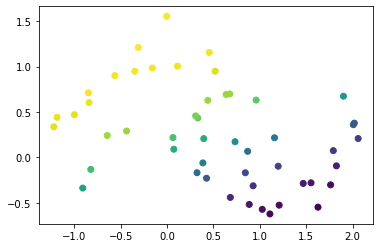

In [14]:
plt.scatter(X[:,0], X[:,1], c = out2)

--> we're predicting whatever because we're not actually fitting the weights

#### Accuracy
- flatten both ytrue and ypred (so that they're both (50,) arrays)
- round the ypred (either up to 1 or down to 0)
- then compare them to eachother to get a boolean array (True where the values are the same, False where they are not)
- sum the boolean array and divide by the length (i.e. take the mean)

In [15]:
def get_accuracy(ypred,ytrue):
    acc = sum(ytrue.flatten() == ypred.flatten().round().astype(np.int64))
    return acc/len(ytrue)

In [16]:
get_accuracy(out2, y)

0.5

--> we're predicting whatever because the weights aren't fitted yet!

### We need something to fit the weights!

## Backpropagation
Use gradient descent to fit the weights of the whole network.

#### Loss function

In [17]:
def log_loss(ytrue, ypred):
    loss = -(ytrue*np.log(ypred) + (1-ytrue)*np.log(1-ypred))
    return loss

#### Gradient (derivative) of the loss function

In [18]:
def loss_gradient(ytrue, ypred):
    loss = -ytrue/ypred + (1-ytrue)/(1-ypred)
    return loss

#### Derivative of the sigmoid function

In [19]:
def sigmoid_deriv(X):
   """derivative of sigmoid with respect to X"""
   return sigmoid(X) * (1-sigmoid(X))

### Backpropagation algorithm from scratch

In [20]:
def backprop(weights, output1, output2, ytrue, X_input, LR_O, LR_H):  
    #we separate learning rates for outer and inner weights.
    
    wH = weights[0]
    wO = weights[1]
    
    #STEP A:
    ytrue = ytrue.reshape(-1, 1) 
    error = loss_gradient(ytrue , output2) 
    
    print(f'Shape of Error: {error.shape}')
   
    #STEP B:
    sig_deriv = sigmoid_deriv(output2)
    #derivative of the sigmoid function with respect to the hidden output * weights
    y_grad = sig_deriv * error
    print(f'Shape of y_grad: {y_grad.shape}')
    
    #STEP C:
    hidden_out_with_bias = np.hstack([output1,np.ones((output1.shape[0] ,1))]) #don't forget the bias!
    delta_wo = np.dot( -y_grad.transpose(), hidden_out_with_bias ) * LR_O
    
    #and finally, old weights + delta weights -> new weights!
    wO_new = wO + delta_wo.transpose()
    print(f'Shape of new outer weights: {wO_new.shape}')

    #STEP D:
    sig_deriv_2 = sigmoid_deriv(output1)
    H_grad = sig_deriv_2  * np.dot(y_grad , wO[:2].transpose()) 
    #exclude the bias (3rd column) of the outer weights, since it is not backpropagated!
    print(f'Shape of H_grad: {H_grad.shape}')
    
    #STEP E:
    delta_wH = np.dot(-H_grad.transpose(), X_input ) * LR_H
    wH_new = wH + delta_wH.transpose() #old weights + delta weights -> new weights!
    print(f'Shape of new hidden weights: {wH_new.shape}')
    
    return wH_new, wO_new

In [21]:
weights_h

array([[ 0.98335114, -0.10485954],
       [-2.5890372 ,  0.26338727],
       [-0.46387692,  0.45181952]])

In [22]:
weights_o

array([[-0.61380891],
       [-0.42614201],
       [-1.29506786]])

#### Run 200 interactions

In [28]:
ACC_VEC = []
# learning_rate = 0.00001 
# learning_rates = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
weights = [weights_h, weights_o]
for i in range(1000):
    out1, out2 =  feed_forward(X, weights)
    ACC_VEC.append(get_accuracy(out2,y))
    new_weights = backprop(weights,out1,out2,y,X, 0.05, 1)
    weights = new_weights

Shape of H_in = (50, 2)
Shape of Error: (50, 1)
Shape of y_grad: (50, 1)
Shape of new outer weights: (3, 1)
Shape of H_grad: (50, 2)
Shape of new hidden weights: (3, 2)
Shape of H_in = (50, 2)
Shape of Error: (50, 1)
Shape of y_grad: (50, 1)
Shape of new outer weights: (3, 1)
Shape of H_grad: (50, 2)
Shape of new hidden weights: (3, 2)
Shape of H_in = (50, 2)
Shape of Error: (50, 1)
Shape of y_grad: (50, 1)
Shape of new outer weights: (3, 1)
Shape of H_grad: (50, 2)
Shape of new hidden weights: (3, 2)
Shape of H_in = (50, 2)
Shape of Error: (50, 1)
Shape of y_grad: (50, 1)
Shape of new outer weights: (3, 1)
Shape of H_grad: (50, 2)
Shape of new hidden weights: (3, 2)
Shape of H_in = (50, 2)
Shape of Error: (50, 1)
Shape of y_grad: (50, 1)
Shape of new outer weights: (3, 1)
Shape of H_grad: (50, 2)
Shape of new hidden weights: (3, 2)
Shape of H_in = (50, 2)
Shape of Error: (50, 1)
Shape of y_grad: (50, 1)
Shape of new outer weights: (3, 1)
Shape of H_grad: (50, 2)
Shape of new hidden we

<ipython-input-7-bfc4509e23b1>:2: RuntimeWarning: overflow encountered in exp
  s = 1/(1+np.exp(-X))


Shape of H_in = (50, 2)
Shape of Error: (50, 1)
Shape of y_grad: (50, 1)
Shape of new outer weights: (3, 1)
Shape of H_grad: (50, 2)
Shape of new hidden weights: (3, 2)
Shape of H_in = (50, 2)
Shape of Error: (50, 1)
Shape of y_grad: (50, 1)
Shape of new outer weights: (3, 1)
Shape of H_grad: (50, 2)
Shape of new hidden weights: (3, 2)
Shape of H_in = (50, 2)
Shape of Error: (50, 1)
Shape of y_grad: (50, 1)
Shape of new outer weights: (3, 1)
Shape of H_grad: (50, 2)
Shape of new hidden weights: (3, 2)
Shape of H_in = (50, 2)
Shape of Error: (50, 1)
Shape of y_grad: (50, 1)
Shape of new outer weights: (3, 1)
Shape of H_grad: (50, 2)
Shape of new hidden weights: (3, 2)
Shape of H_in = (50, 2)
Shape of Error: (50, 1)
Shape of y_grad: (50, 1)
Shape of new outer weights: (3, 1)
Shape of H_grad: (50, 2)
Shape of new hidden weights: (3, 2)
Shape of H_in = (50, 2)
Shape of Error: (50, 1)
Shape of y_grad: (50, 1)
Shape of new outer weights: (3, 1)
Shape of H_grad: (50, 2)
Shape of new hidden we

In [24]:
max(ACC_VEC)

0.82

Text(0, 0.5, 'accuracy')

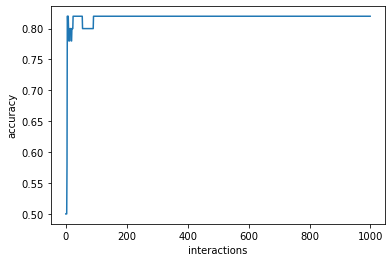

In [25]:
import matplotlib.pyplot as plt
plt.plot(ACC_VEC)
plt.xlabel('interactions')
plt.ylabel('accuracy')

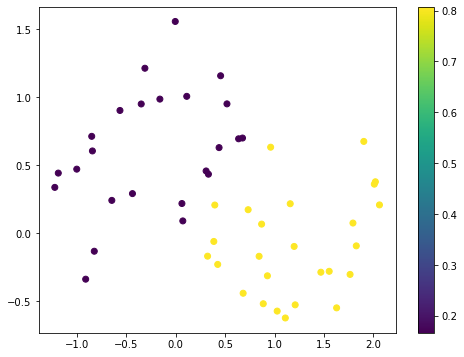

In [26]:
plt.figure(figsize = (8,6))
plt.scatter(X[:,0], X[:,1], c = out2)
plt.colorbar()

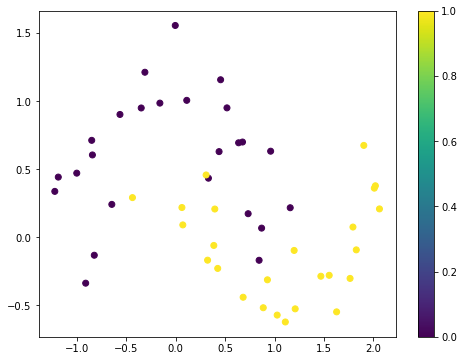

In [27]:
plt.figure(figsize = (8,6))
plt.scatter(X[:,0], X[:,1], c = y)
plt.colorbar()